In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
import itertools

In [2]:
tf.random.set_seed(42)
np.random.seed(1337)

In [3]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Unzip folder and define data directory.
data_source = "/content/drive/MyDrive/Covid_Dataset.rar" 
data_output = "/content"
!unrar x -Y "/content/drive/MyDrive/Covid_Dataset.rar" "/content"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Covid_Dataset/train/Normal/Normal_1077.png           50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10770.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10771.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10772.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10773.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10774.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10775.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10776.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10778.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10781.png          50%  OK 
Extracting  /content/Covid_Da

In [16]:
#Define the hyper parameters
data_dir = '/content/Covid_Dataset'
classes = ['COVID', 'Normal']
initial_epochs = 50
initial_LR = 0.0001
dropout =.5
batch_size =128
configuration = 'VGG16_'+str(initial_LR)+'_WD_'+str(dropout)+'_'+str(batch_size)

In [17]:
#Define the data paths
train_path = data_dir + '//train'
valid_path = data_dir + '//valid'
test_path = data_dir + '//test'

In [18]:
#Define batches and use the preprocessing function of VGG16
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, classes=classes, batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, classes=classes, batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, classes=classes, batch_size=batch_size, shuffle=False)

Found 8500 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


In [19]:
#Define input shape and use the weights from Imagenet and the network is a VGG16
INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.vgg16.VGG16(input_shape= INPUT_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True

In [20]:
#for layer in base_model.layers[:2]:
#  layer.trainable = False
for layer in base_model.layers:
  if('block1' in layer.name or 'block2' in layer.name):
    continue
  else:
    layer.trainable = False

In [21]:
#Define the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(Dense(2, activation = 'sigmoid'))

In [22]:
#Prints a summary of the network.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 261,186
Non-trainable params: 14,454,528
_________________________________________________________________


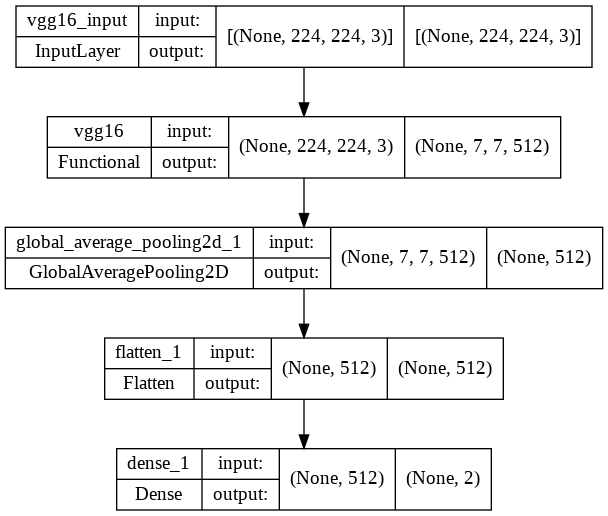

In [23]:
#Plot the model
tf.keras.utils.plot_model(model, to_file= '/content/'+configuration+'_MODEL.png', show_shapes=True, show_layer_names=True)

In [24]:
#Stop training when a monitored metric has stopped improving
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

#Callback to save the Keras model or model weights at some frequency.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(configuration+'.h5', monitor='val_loss', save_best_only=True, mode='min')

#Configures the model for training
model.compile(optimizer=Adam(learning_rate=initial_LR), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
#Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
      train_batches,
      epochs = initial_epochs,
      validation_data=valid_batches,
      verbose=1,
      callbacks = [earlystopping_callback,checkpoint_callback]
    )

Epoch 1/50
67/67 [==============================] - 90s 1s/step - loss: 0.6391 - accuracy: 0.7085 - val_loss: 0.5015 - val_accuracy: 0.7675
Epoch 2/50
67/67 [==============================] - 68s 1s/step - loss: 0.4096 - accuracy: 0.8346 - val_loss: 0.4031 - val_accuracy: 0.8275
Epoch 3/50
67/67 [==============================] - 68s 1s/step - loss: 0.3349 - accuracy: 0.8753 - val_loss: 0.3476 - val_accuracy: 0.8725
Epoch 4/50
67/67 [==============================] - 68s 1s/step - loss: 0.2869 - accuracy: 0.8966 - val_loss: 0.3147 - val_accuracy: 0.8825
Epoch 5/50
67/67 [==============================] - 68s 1s/step - loss: 0.2446 - accuracy: 0.9194 - val_loss: 0.2642 - val_accuracy: 0.9150
Epoch 6/50
67/67 [==============================] - 68s 1s/step - loss: 0.2103 - accuracy: 0.9335 - val_loss: 0.2358 - val_accuracy: 0.9250
Epoch 7/50
67/67 [==============================] - 68s 1s/step - loss: 0.1844 - accuracy: 0.9439 - val_loss: 0.2033 - val_accuracy: 0.9375
Epoch 8/50
67/67 [==

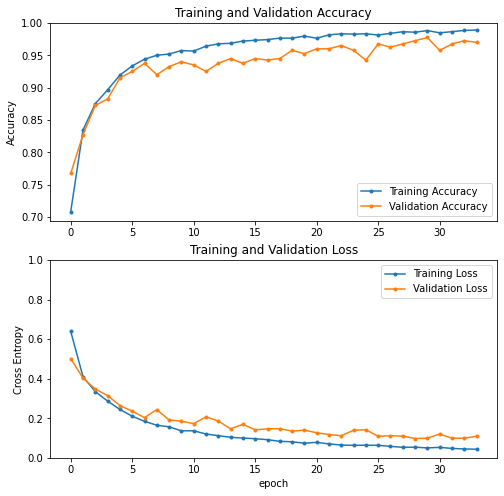

In [26]:
# Plot (training and validation) accuracy and loss figures respectively
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker = '.')
plt.plot(val_acc, label='Validation Accuracy', marker = '.')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker = '.')
plt.plot(val_loss, label='Validation Loss', marker = '.')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/'+configuration+'_CURVE.png')
plt.show()

In [27]:
ran_epochs = len(history.history['accuracy'])
best_epoch = 0
if(ran_epochs != 50):
  if(ran_epochs > 5):
    best_epoch = ran_epochs - 6  
  else:
    best_epoch = 0
else:
  best_epoch = 49

In [28]:
train_accuracy = history.history['accuracy'][best_epoch]
train_loss = history.history['loss'][best_epoch]
train_accuracy = round(train_accuracy * 100,2)
train_loss = round(train_loss,2)
print(f'Training Accuracy: {train_accuracy}%')
print(f'Training Loss: {train_loss}')

Training Accuracy: 98.56%
Training Loss: 0.05


In [29]:
valid_accuracy = history.history['val_accuracy'][best_epoch]
valid_loss = history.history['val_loss'][best_epoch]
valid_accuracy = round(valid_accuracy * 100,2)
valid_loss = round(valid_loss,2)
print(f'Validation Accuracy: {valid_accuracy}%')
print(f'Validation Loss: {valid_loss}')

Validation Accuracy: 97.25%
Validation Loss: 0.1


In [30]:
#Returns the loss value & metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(test_batches)
test_accuracy = round(test_accuracy * 100,2)
test_loss = round(test_loss,2)
print(f'Testing Accuracy: {test_accuracy}%')
print(f'Testing Loss: {test_loss}')

10/10 [==============================] - 8s 836ms/step - loss: 0.0815 - accuracy: 0.9752
Testing Accuracy: 97.52%
Testing Loss: 0.08


In [31]:
#Print the results in a dataframe 
results = {'Training Accuracy': train_accuracy, 'Training Loss':train_loss,
           'Validation Accuracy':valid_accuracy,'Validation Loss':valid_loss,
           'Testing Accuracy':test_accuracy,'Testing Loss':test_loss}
results_df = pd.DataFrame(results, index = [configuration])
results_df = results_df.round(2)
results_df.to_csv('/content/'+configuration+'_RESULTS.csv')
results_df

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Testing Accuracy,Testing Loss
VGG16_0.0001_WD_0.5_128,98.56,0.05,97.25,0.1,97.52,0.08


In [32]:
#Generates output predictions for the input samples.
predictions = model.predict(x=test_batches, verbose = 1)

10/10 [==============================] - 5s 414ms/step


In [33]:
#Print a classification report
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=classes, output_dict=True)
df = pd.DataFrame(cr).transpose()
df = df.round(2)
df.to_csv('/content/'+configuration+'_CR.csv')
print(df)

              precision  recall  f1-score  support
COVID              0.98    0.97      0.98   626.00
Normal             0.97    0.98      0.98   626.00
accuracy           0.98    0.98      0.98     0.98
macro avg          0.98    0.98      0.98  1252.00
weighted avg       0.98    0.98      0.98  1252.00


In [34]:
#Define a function to use in plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/'+configuration+'_CM.png')

Confusion matrix, without normalization


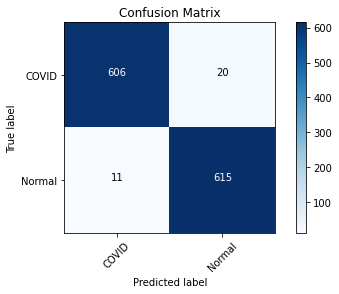

In [35]:
#Plot the confusion matrix 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')